In [2]:
import matplotlib.pyplot as plt
import numbers
import numpy as np
import scipy
from scipy.integrate import quad
from scipy import optimize
from scipy import stats

In [3]:
kpc_to_cm = 3.086e21  # 1 kpc in cm
cm_to_kpc = 1 / kpc_to_cm
GeV_to_m_sun = 1 / 1.11543e57
m_sun_to_GeV = 1 / GeV_to_m_sun
GeV_to_erg = 0.001602
erg_to_GeV = 1 / GeV_to_erg
yr_to_s = 365. * 24 * 60**2
s_to_yr = 1 / yr_to_s
L_sun_to_GeV_s = 2.402e36
GeV_s_to_L_sun = 1 / L_sun_to_GeV_s
L_sun_to_erg_s = L_sun_to_GeV_s * GeV_to_erg
erg_s_to_L_sun = 1 / L_sun_to_erg_s

# Best-fit Einasto parameters for Milky Way halo. From PPPC.
alpha_mw = 0.17
r_s_mw = 28.44  # kpc
rho_e_mw = 0.033 * GeV_to_m_sun / cm_to_kpc**3  # M_sun / kpc^3

def rho_einasto(r, rho_e, r_s, alpha):
    """Einasto density profile."""
    return rho_e * np.exp(-2/alpha * ((r / r_s)**alpha - 1))

# Corresponding probability distributions for coordinates
r_dist = stats.gengamma(a=3/alpha_mw, c=alpha_mw, loc=0, scale=r_s_mw*(alpha_mw/2)**(1/alpha_mw))
th_dist = stats.uniform(0, np.pi)
phi_dist = stats.uniform(0, 2*np.pi)

# Total MW DM mass in M_sun. Cross-checked with PPPC.
m_mw_dm = quad(lambda r: 4*np.pi*r**2*rho_einasto(r, rho_e_mw, r_s_mw, alpha_mw),
               0., np.inf, epsabs=0, epsrel=1e-4)[0]

Omega_cdm = 0.2589  # from Planck 2015
z_eq = 3500.
z_final = 30.  # redshift at which to end PBH halo evolution
d_earth = 8.33  # kpc
age_of_universe = 13e9  # yr
fermi_psf = 0.15 * np.pi / 180.  # arxiv:0902.1089
fermi_psf_solid_angle = 2.*np.pi*(1. - np.cos(fermi_psf))
# Particle physics
alpha_em = 1/137.
m_e = 0.511e-3  # GeV
m_mu = 105.7e-3  # GeV
m_tau = 1.776  # GeV

def gamma_spec_int(m_dm, e_low, e_high, fs="g g"):
    """Computes the integral of the photon spectrum from DM annihilating
    into a final state.
    
    Notes
    -----
    Uses the Altarelli-Parisi approximation for FSR from leptons.
    
    Parameters
    ----------
    m_dm
        DM mass, GeV.
    e_low, e_high
        Energy interval, GeV.
    fs : string
    
    Returns
    -------
    Number of photons produced per annihilation in the specified energy
    range.
    """
    if fs == "g g":
        return 2.
    elif fs == "e e":
        return alpha_em/np.pi * np.log(e_high/e_low) * np.log(4*m_dm/m_e)
    elif fs == "mu mu":
        return alpha_em/np.pi * np.log(e_high/e_low) * np.log(4*m_dm/m_mu)
    elif fs == "tau tau":
        return alpha_em/np.pi * np.log(e_high/e_low) * np.log(4*m_dm/m_tau)
    else:
        raise ValueError("Unknown final state")

def to_galactic_coords(r, th, phi, deg=True):
    """Converts from spherical coordinates centered on the GC to galactic coordinates."""
    x = r * np.sin(th) * np.cos(phi)
    y = r * np.sin(th) * np.sin(phi)
    z = r * np.cos(th)
    
    d = np.sqrt((x + d_earth)**2 + y**2 + z**2)
    b = np.pi/2 - np.arccos(z / d)
    l = np.arctan2(y, x + d_earth)
    
    if deg:
        return np.stack([d, 180/np.pi*b, 180/np.pi*l])
    else:
        return np.stack([d, b, l])

In [40]:
def gamma_energy_flux(m_dm, e_low, e_high, fs="g g"):
    """Computes the integral of the photon spectrum from DM annihilating
    into a final state.
    
    Notes
    -----
    Uses the Altarelli-Parisi approximation for FSR from leptons.
    
    Parameters
    ----------
    m_dm
        DM mass, GeV.
    e_low, e_high
        Energy interval, GeV.
    fs : string
    
    Returns
    -------
    Number of photons produced per annihilation in the specified energy
    range.
    """
    if fs == "g g":
        return 2.
    elif fs == "e e":
        return alpha_em/np.pi * (e_high - e_low) * np.log(4*m_dm/m_e)
    elif fs == "mu mu":
        return alpha_em/np.pi * (e_high - e_low) * np.log(4*m_dm/m_mu)
    elif fs == "tau tau":
        return alpha_em/np.pi * (e_high - e_low) * np.log(4*m_dm/m_tau)
    else:
        raise ValueError("Unknown final state")

        
def max_dm_density(m_dm, sv):
    """
    Parameters
    ----------
    m_dm : float
        Dark matter mass, GeV.
    sv : float
        cm^3 / s.

    Returns
    -------
    Maximum DM density in GeV / cm^3.
    """
    return m_dm / (sv * age_of_universe * yr_to_s)


def pbh_halo_mass(m_pbh, z=z_eq):
    """From arxiv:0706.0864. M_sun."""
    return m_pbh * (1 + z_eq) / (1 + z_final)


def pbh_halo_truncation_radius(m_halo, z=z_eq):
    """From arxiv:0706.0864. kpc."""
    return 58e-3 * m_halo**(1/3) * 1 / (1 + z) / 3


def ann_plateau_radius(nu, r_tr, m_halo, rho_max):
    """kpc."""
    def helper(r_tr, m_halo, rho_max):
        def f(r_p):
            r_term = 3*r_p**nu*r_tr**(3-nu) - nu*r_p**3
            rho_max_astro = rho_max * GeV_to_m_sun / cm_to_kpc**3
            return r_term - (9-3*nu) * m_halo / (4*np.pi*rho_max_astro)
        
        def fprime(r_p):
            return 3*r_p**(nu-1)*r_tr**(3-nu)*nu - 3*r_p**2*nu
        
        sol = optimize.root_scalar(f, x0=1e-5*r_tr, fprime=fprime, method="newton",
                                   xtol=1e-100, rtol=1e-5)
        root = np.real(sol.root)
        if root < 0:
            raise ValueError("r_p is negative.")
        elif root > r_tr:
            raise ValueError("r_p is larger than the truncation radius.")
        elif np.imag(sol.root) / root > 1e-5:
            raise ValueError("r_p is imaginary")
        else:
            return root
    return np.vectorize(helper)(r_tr, m_halo, rho_max)


def pbh_halo_luminosity(m_pbh, nu, m_dm, sv, ignore_ann_plateau=False):
    """
    Notes
    -----
    Assumes the DM is self-conjugate.

    Parameters
    ----------
    ignore_ann_plateau : bool
        If true, assume
            rho_dm(r) = A / r^nu, r < r_tr.
        If false, assume
            rho_dm(r) = rho_max for r < r_p
            rho_dm(r) = rho_max*(r_p/r)^nu for r_p < r < r_tr.
    
    Returns
    -------
    UCMH luminosity in erg/s.
    """
    if nu != 3/2:
        raise ValueError("nu must be 3/2")
    # From BL10:
    r_p = 6.3e-6 * 4.848e-9 * m_pbh**0.23 * kpc_to_cm
    r_tr = 1300*4.848e-9 * m_pbh**(1/3) * (1+z_eq) / (1+z_eq) * kpc_to_cm
    # From R07. As in BL, stop halo evolution at z_eq.
#     m_halo = pbh_halo_mass(m_pbh, z_eq)  # M_sun
#     r_tr = pbh_halo_truncation_radius(m_halo, z_eq) * kpc_to_cm
    # From BL10
    return (9/(32*np.pi) * (m_sun_to_GeV*m_pbh)**2 * sv / (m_dm * r_tr**3) *
            np.log(r_tr / r_p) * GeV_to_erg)
    # With standard value for rho_max:
#     m_halo = pbh_halo_mass(m_pbh)  # M_sun
#     r_tr = pbh_halo_truncation_radius(m_halo)  # kpc
#     if ignore_ann_plateau:
#         if nu < 1.5:
#             return m_dm*GeV_to_erg*m_halo**2*sv*(3-nu)**2 / (8*np.pi*m_dm**2*r_tr**3*(3-2*nu))
#         else:
#             raise ValueError("Cannot ignore annihilation plateau when nu > 1.5.")
#     else:
#         rho_max = max_dm_density(m_dm, sv)  # GeV / cm^3
#         r_p = ann_plateau_radius(nu, r_tr, m_halo, rho_max)  # kpc
#         print("r_p, r_tr:", r_p, r_tr)
#         if nu == 3/2:
#             r_term = (kpc_to_cm * r_p)**3 * (1 + 3 * np.log(r_tr / r_p))
#             return m_dm*GeV_to_erg * 2*np.pi*sv*rho_max**2*r_term / (3*m_dm**2)
#         else:
#             r_term = (3*(r_p/r_tr)**(2*nu)*r_tr**3 - 2*nu*r_p**3) * kpc_to_cm**3
#             return m_dm*GeV_to_erg * 2*np.pi*sv*rho_max**2*r_term / (m_dm**2*(9-6*nu))


def to_galactic_coords(r, th, phi, deg=True):
    """Converts from spherical coordinates centered on the GC to galactic coordinates."""
    x = r * np.sin(th) * np.cos(phi)
    y = r * np.sin(th) * np.sin(phi)
    z = r * np.cos(th)
    
    d = np.sqrt((x + d_earth)**2 + y**2 + z**2)
    b = np.pi/2 - np.arccos(z / d)
    l = np.arctan2(y, x + d_earth)
    
    if deg:
        return np.stack([d, 180/np.pi*b, 180/np.pi*l])
    else:
        return np.stack([d, b, l])


def gen_pbhs(n_samples=1, mass_dist=1, f_pbh=1, nu=2.25, m_dm=100., sv=3e-26,
             e_low=1, e_high=100., fs="g g", dOmega=fermi_psf_solid_angle):
    """
    Parameters
    ----------
    n_samples : int
        Number of PBHs to generate.
    mass_dist : float or scipy.stats.rv_continuous
        PBH mass probability distribution. A float can be passed to represent a
        monochromatic mass function.
    f_pbh : float
        PBH abundance divided by DM abundance. Defaults to 1.
        
    Returns
    -------
    m_pbh
        Sampled PBH masses.
    position
        Sampled positions in galactic coordinates (d, b, l) (kpc, deg, deg).
    sample_scaling
        Factor required to scale n_samples by so the total of the sampled PBH masses
        matches the amount of MW halo mass the PBHs should comprise. Eg, all histogram
        counts should be rescaled by sample_scaling.
    """
    position = np.stack([r_dist.rvs(n_samples),
                         th_dist.rvs(n_samples),
                         phi_dist.rvs(n_samples)])
    position = to_galactic_coords(*position)
    
    if type(mass_dist) == int:
        m_pbh = mass_dist * np.ones(n_samples)
        lum = pbh_halo_luminosity(mass_dist, nu, m_dm, sv) * np.ones(n_samples)
    else:
        m_pbh = mass_dist.rvs(n_samples)
        lum = pbh_halo_luminosity(m_pbh, nu, m_dm, sv)
    
    int_spectrum = gamma_spec_int(m_dm, e_low, e_high, fs)
    e_flux = lum * dOmega/(4*np.pi*(kpc_to_cm*position[0])**2) * int_spectrum
    
    sample_scaling = f_pbh * m_mw_dm / np.sum(m_pbh)
    
    return m_pbh, lum, e_flux, position, sample_scaling


# def pbh_halo_flux(lum, position, m_dm, e_low=1, e_high=100, fs="g g", dOmega=fermi_psf_solid_angle):
#     # erg / s / cm**2
#     int_spectrum = gamma_spec_int(m_dm, e_low, e_high, fs)
#     return lum * dOmega/(4*np.pi*(kpc_to_cm*position[0])**2) * int_spectrum


def num_detectable_pbh_halos(m_pbh, e_flux, position, scaling, b_cut=10, e_flux_thresh=1e-12):
    # Cut on |b|
    passed_b_idx = np.where(np.abs(positions[1]) > 10.)[0]
    e_flux_pass = e_flux[passed_b_idx]
    return e_flux_pass[e_flux_pass > e_flux_thresh].size * scaling

In [43]:
m_pbh = 1.
m_dm = 10.
sv = 3e-26
nu = 3/2

m_halo = pbh_halo_mass(m_pbh)  # M_sun
r_tr = pbh_halo_truncation_radius(m_halo)  # kpc
rho_max = max_dm_density(m_dm, sv)  # GeV / cm^3
r_p = ann_plateau_radius(nu, r_tr, m_halo, rho_max)  # kpc

ValueError: r_p is larger than the truncation radius.

In [9]:
n_det_fn = []

for _ in range(100):
    m_pbhs, lums, e_fluxes, positions, scaling = gen_pbhs(1000, mass_dist=1,
                                                          m_dm=5, nu=3/2,
                                                          f_pbh=1e-4, sv=3e-26)
    n_det_fn.append(num_detectable_pbh_halos(m_pbhs, e_fluxes, positions, scaling))

In [10]:
np.mean(n_det_fn), np.std(n_det_fn)

(0.0, 0.0)

In [11]:
num_detectable_pbh_halos(m_pbhs, e_fluxes, positions, scaling)

0.0

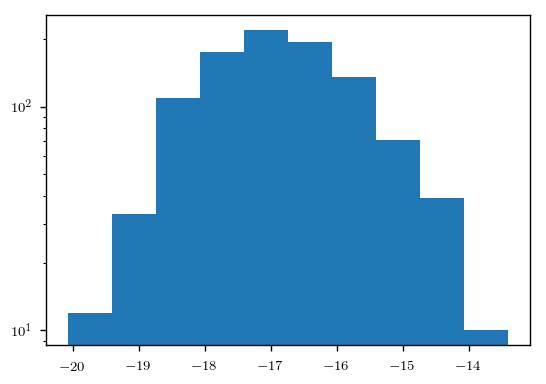

In [12]:
plt.hist(np.log10(e_fluxes))
plt.yscale("log")

# Tests

## Comparison with [Beacom and Lacki](https://arxiv.org/pdf/1003.3466.pdf)

We agree up to a factor of 50, which could be due to the

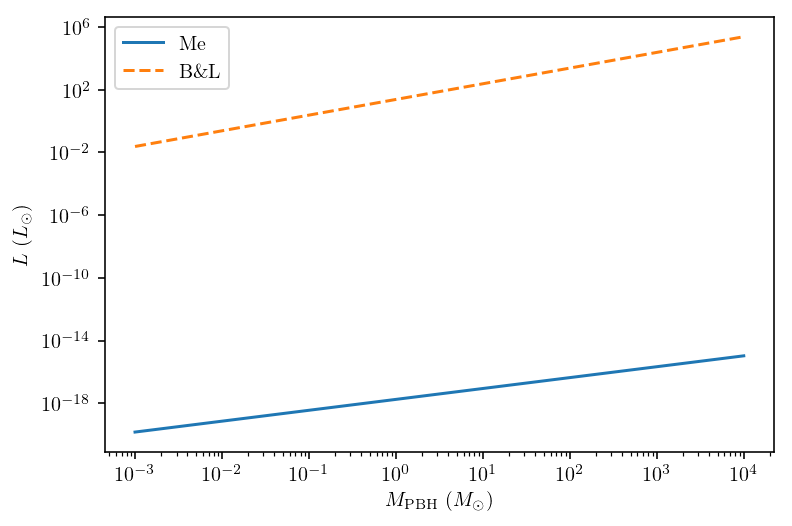

In [151]:
lums = []
m_pbhs = np.logspace(-3, 4)
for m in m_pbhs:
    lums.append(erg_s_to_L_sun * gen_pbhs(1, mass_dist=m, m_dm=1e2, nu=1.49)[1][0])
lums = np.array(lums)

plt.loglog(m_pbhs, lums, label="Me")
plt.loglog(m_pbhs, 24 * m_pbhs, '--', label=r"B\&L")
plt.xlabel(r"$M_{\mathrm{PBH}}$ ($M_\odot$)")
plt.ylabel(r"$L$ ($L_\odot$)")
plt.legend()

(-90, 90)

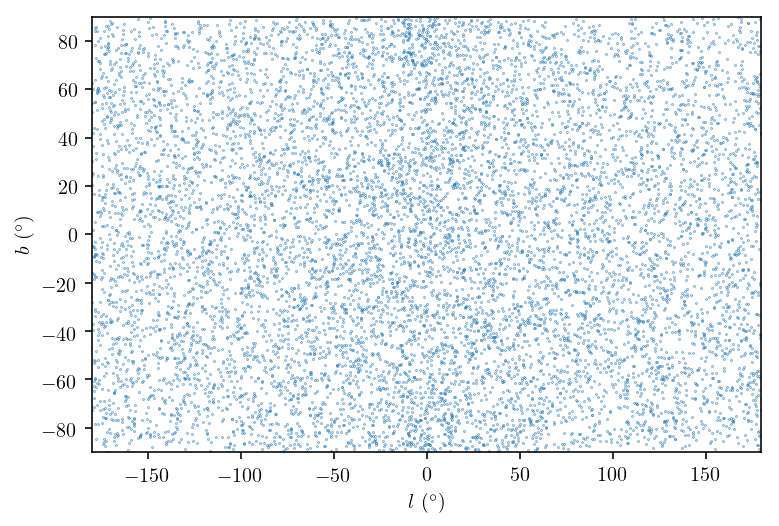

In [43]:
plt.plot(positions[2], positions[1], '.', markersize=0.5)
plt.xlabel(r"$l~(^\circ)$")
plt.ylabel(r"$b~(^\circ)$")
plt.xlim(-180, 180)
plt.ylim(-90, 90)

Text(0.5, 1.0, 'l')

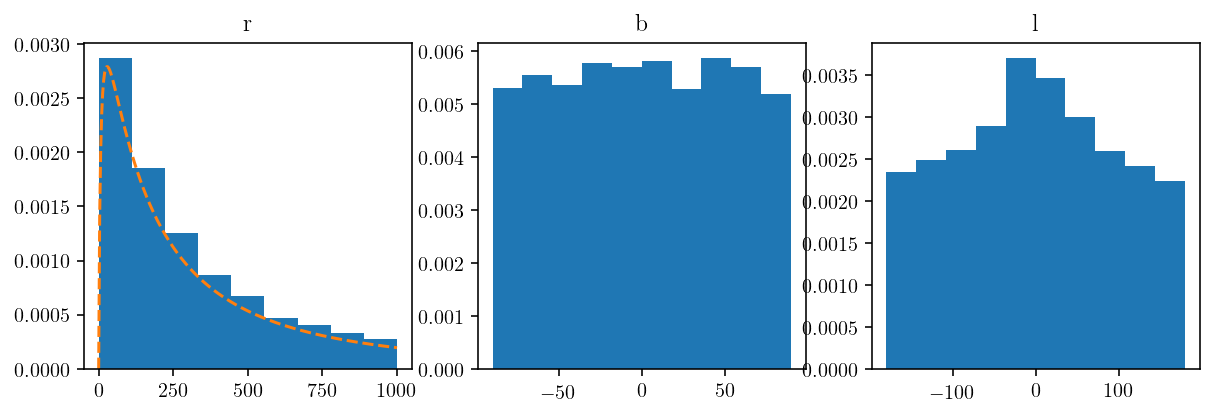

In [36]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
r_max = 1000
rs = np.linspace(0, r_max, 300)
plt.hist(positions[0], density=True, bins=np.linspace(0, r_max, 10))
plt.plot(rs, r_dist.pdf(rs), '--')
plt.title("r")

plt.subplot(1, 3, 2)
plt.hist(positions[1], density=True)
plt.title("b")

plt.subplot(1, 3, 3)
plt.hist(positions[2], density=True)
plt.title("l")